In [1]:
import utils
import pandas as pd
import matplotlib.pyplot as plt
import os
import geopandas as gpd
from datetime import datetime,timedelta
import matplotlib.dates as mdates
import sys 
import csv

from utils import *

country_iso_3 = sys.argv[1]

ASSESSMENT_DATE='2020-09-09'
# TODAY = date.today()
TODAY = datetime.strptime(ASSESSMENT_DATE, '%Y-%m-%d').date()
FOUR_WEEKS = TODAY + timedelta(days=28)
TWO_WEEKS = TODAY + timedelta(days=14)
LAST_TWO_MONTHS = TODAY - timedelta(days=60)

MIN_QUANTILE=0.25
MAX_QUANTILE=0.75
# MIN_QUANTILE=0.05
# MAX_QUANTILE=0.95

CONFIG_FILE = 'config.yml'
# DIR_PATH = os.path.dirname(os.path.realpath(__file__))
WHO_COVID_URL='https://covid19.who.int/WHO-COVID-19-global-data.csv'
WHO_COVID_FILENAME='WHO_data/WHO-COVID-19-global-data.csv'
RESULTS_FILENAME=f'automated_reports/report_metrics/{country_iso_3}_results.csv'

NPI_COLOR='green'
NO_NPI_COLOR='red'
WHO_DATA_COLOR='dodgerblue'
SUBNATIONAL_DATA_COLOR='navy'

In [2]:
country_iso3="SDN"# AFG SSD SDN COD SOM IRQ
parameters = utils.parse_yaml(CONFIG_FILE)[country_iso3]
#     if download_covid:
#         # Download latest covid file tiles and read them in
#         download_who_covid_data(WHO_COVID_URL,f'{DIR_PATH}/{WHO_COVID_FILENAME}')
set_matlotlib(plt)
# print('\n\n\n')
# print(f'{country_iso3}')

In [68]:
from mapclassify import UserDefined
import mapclassify as mc

In [7]:
hist_data=get_who(WHO_COVID_FILENAME,parameters['iso2_code'],min_date=pd.to_datetime('2000-01-01'),max_date=FOUR_WEEKS)

In [8]:
hist_data

,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
Date_reported,,,,,,,
2020-03-14,SD,Sudan,EMRO,5,5,0,0
2020-03-15,SD,Sudan,EMRO,0,5,1,1
2020-03-16,SD,Sudan,EMRO,0,5,0,1
2020-03-17,SD,Sudan,EMRO,0,5,0,1
2020-03-18,SD,Sudan,EMRO,0,5,0,1
...,...,...,...,...,...,...,...
2020-09-06,SD,Sudan,EMRO,218,13407,9,832
2020-09-07,SD,Sudan,EMRO,30,13437,1,833
2020-09-08,SD,Sudan,EMRO,0,13437,0,833


In [16]:
hist_bucky["cases_per_100k"]=hist_bucky["cases_per_100k"].astype(int)

In [17]:
cases_max=hist_bucky.cases_per_100k.max()

In [18]:
cases_min=hist_bucky.cases_per_100k.min()

In [19]:
cases_min

0

In [29]:
import numpy

In [76]:
mc.EqualInterval([0,110], k=5).bins

array([ 22.,  44.,  66.,  88., 110.])

In [39]:
numpy.linspace(0,110,5,dtype=int)

array([  0,  27,  55,  82, 110])

In [135]:
def create_subnational_map(country_iso3, parameters):
    # Total cases - four weeks projection
    parameters = utils.parse_yaml(CONFIG_FILE)[country_iso3]
    bucky_npi =  get_bucky(country_iso3 ,admin_level='adm1',min_date=TODAY,max_date=TWO_WEEKS,npi_filter='npi')
    bucky_npi = bucky_npi[bucky_npi['q']==0.5][['adm1','cases_per_100k']]
    bucky_npi = bucky_npi.loc[TWO_WEEKS,:]
    adm1_pcode_prefix=parameters['iso2_code']
    if country_iso3 == 'IRQ':
        adm1_pcode_prefix='IQG'
    bucky_npi['adm1']=adm1_pcode_prefix + bucky_npi['adm1'].apply(lambda x:  "{0:0=2d}".format(int(x)))
    bucky_npi["cases_per_100k"]=bucky_npi["cases_per_100k"].astype(int)
    shapefile = gpd.read_file(parameters['shape'])
    shapefile = shapefile.merge(bucky_npi, left_on=parameters['adm1_pcode'], right_on='adm1', how='left')
    fig_title=f'{country_iso3}: Projected number of cases per 100,000 people'
    # fig_title=f'Ranking: number of cases per 100,000 people on {TWO_WEEKS}'
    fig,axis=create_new_subplot(fig_title)
    axis.axis('off')
    
    hist_bucky=get_bucky(country_iso3 ,admin_level='adm1',min_date=pd.to_datetime('2000-01-01'),max_date=FOUR_WEEKS,npi_filter='npi')
    hist_bucky["cases_per_100k"]=hist_bucky["cases_per_100k"].astype(int)
    cases_max=hist_bucky["cases_per_100k"].max()
#     cases_min=hist_bucky["cases_per_100k"].min()
    scheme="UserDefined"#'quantiles'
    num_colors=5#min(5,len(bucky_npi.cases_per_100k.unique()))
    cmap="YlOrRd"#"viridis"#"YlOrRd"#"viridis"
#     bins_list=[0,10,50,70,200,300,400,600,900,1200,1700,2400,5000] 
#     shapefile["cases_per_100k"]=shapefile["cases_per_100k"].astype(int)
#     max_cases=shapefile["cases_per_100k"].max()
#     max_bin=next(x[0] for x in enumerate(bins_list) if x[1] > max_cases)
#     bins_listc=bins_list[:1+next(x[0] for x in enumerate(bins_list) if x[1] > max_cases)]
#     print(bins_listc)
    bins_list=numpy.linspace(0,cases_max,num_colors+1,dtype=int)[1:]
#     bins_list=mc.EqualInterval([0,cases_max*1.2], k=5)
#     bins_list=mc.EqualInterval(bucky_npi.cases_per_100k, k=5)
# q10 = mapclassify.Quantiles(gdf.SIDR79,k=10)
    print(bins_list)
    print(bucky_npi.cases_per_100k.unique())
#     shapefile.plot(column='cases_per_100k',ax=axis,cmap='OrRd',legend_kwds={"title":"bla"},legend=True
# #                       legend_kwds={'orientation': "horizontal"}
#                    )
#,missing_kwds={"color":"lightgrey"}) # scheme = scheme,#, figsize=(10, 10),edgecolor='gray',ax=axis,
#                 #    legend=True,
#     shapefile.plot('cases_per_100k',  ax=axis, cmap=cmap
#                    ,scheme=scheme, legend=True, legend_kwds=dict(loc='upper right', bbox_to_anchor=(1.5, 0.75)),
#             classification_kwds=dict(bins=bins_list)#,orientation="horizontal")

# )
    
#     shapefile.assign(cl=UserDefined(shapefile["cases_per_100k"].dropna(), bins_list)).plot(
#     column='cl', ax=ax1, cmap='OrRd'
# )
    
#     shapefile.assign(cl=UserDefined(shapefile['cases_per_100k'].dropna(), bins_list).yb).plot(column='cl',  k=10, cmap='OrRd', linewidth=0.1, ax=axis, edgecolor='white', legend=True)
#     shapefile.assign(cl=bins_list.yb).plot(column='cl',  k=10, cmap='OrRd', linewidth=0.1, ax=axis, edgecolor='white', legend=True) #categorical=True,
    shapefile.plot('cases_per_100k',  ax=axis, cmap=cmap, legend=True
               ,scheme=scheme,
         legend_kwds=dict(loc='upper right', bbox_to_anchor=(1.5, 0.75), title="Legend\n", frameon=False),
        classification_kwds=dict(bins=bins_list)#)#,orientation="horizontal")

    )
#     fig.colorbar(axis.collections[0], ax=axis)
#     shapefile.plot(column='cases_per_100k', figsize=(10, 10),edgecolor='gray',ax=axis,
#                    legend=True,
#                 #    legend_kwds={'label': "Cases per 100,000 people",'orientation': "horizontal"},
#                    scheme='Quantiles',k=len(shapefile)
#                    )
#     print(shapefile.cases_per_100k.value_counts())
    vmin = shapefile.cases_per_100k.min()
    vmax = shapefile.cases_per_100k.max()
    
#     cax = fig.add_axes([0.1, 0.1, 0.8,0.03])
# #     cax = fig.add_axes([1, 0.1, 0.03, 0.8])
#     sm = plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(vmin=vmin, vmax=vmax))
#     sm._A = []
#     cbr = fig.colorbar(sm, cax=cax, orientation="horizontal")
#     shapefile.boundary.plot(linewidth=0.1,ax=axis)
#     fig.savefig(f'Outputs/{country_iso3}/map_cases_per_100k_2w.png')

#     leg = axis.get_legend()
# #     print(max_bin)
#     for lbl in leg.get_texts():
#         label_text = lbl.get_text()
#     #                 print(label_text)
# #         print(label_text)
#         upper = label_text.split(",")[-1].rstrip(']')

# #         print("f",upper)
#         if int(float(upper)) > bins_listc[-1]:
# #             print("blub")
#             new_text = f'_'
#         else:
#             new_text=label_text
#         lbl.set_text(new_text)
    plt.show()

[ 57 115 173 231 289]
[147   0  13   6  53   3   5  38]


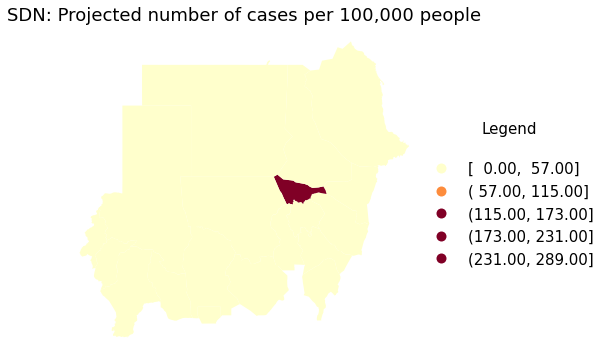

[ 28  56  84 112 140]
[ 9  0  4 13  5  2 11 21 59 65 36  3 41 12 25 10]


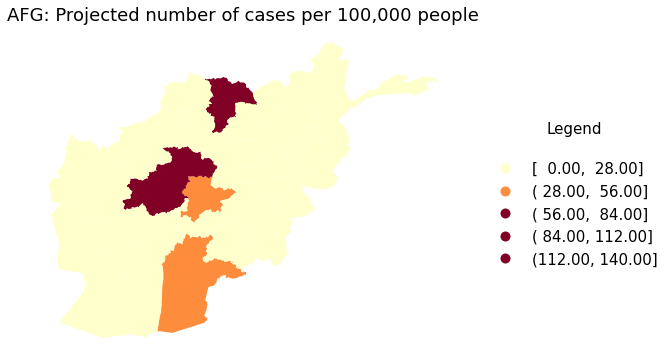

[0 0 1 1 2]
[0 1]


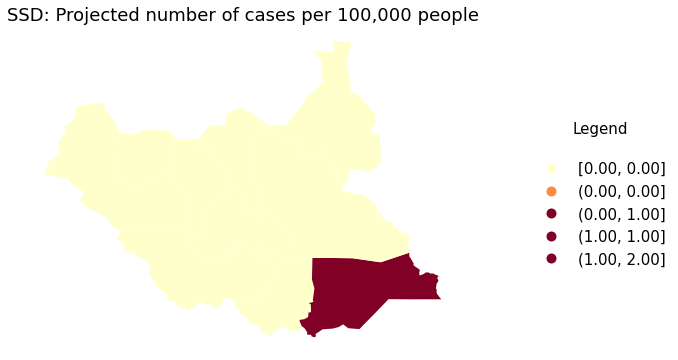

[ 3  7 10 14 18]
[8 0 2]


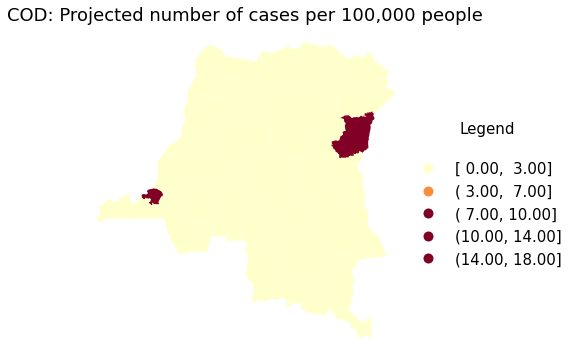

[16 32 49 65 82]
[ 1 39  0  2]


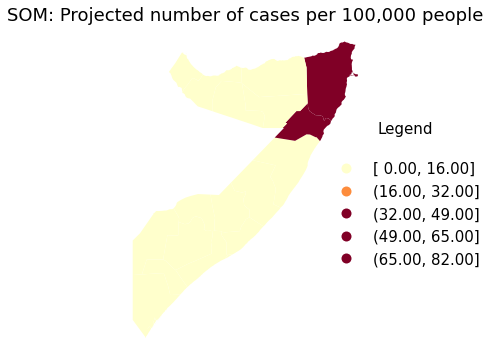

[1048 2096 3144 4192 5241]
[ 340  715 1416  707 1056  736  493 2251 1364  699  798  879  809  928
  612  694 1235 1086]


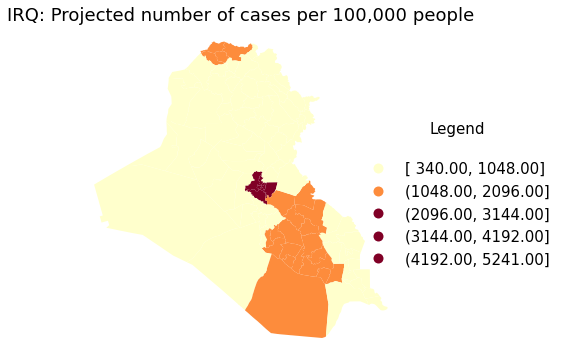

In [136]:
for country_iso3 in ["SDN","AFG", "SSD", "COD", "SOM", "IRQ"]:
    parameters = utils.parse_yaml(CONFIG_FILE)[country_iso3]
    create_subnational_map(country_iso3,parameters)

In [154]:
# bins = Quantiles(pop_gdf['central_pop'], 5).bins


# pop_gdf.assign(cl=User_Defined(pop_gdf['low_pop'].dropna(), bins).yb).plot(
#     column='cl', ax=ax1, cmap='OrRd'
# )
# pop_gdf.plot('central_pop', scheme='quantiles',  ax=ax2, cmap='OrRd', legend=True, cax=ax3,
#              legend_kwds=dict(loc='upper right', bbox_to_anchor=(3.5, 0.75), title="Legend\n", frameon=False)

# )
# pop_gdf.assign(cl=User_Defined(pop_gdf['high_pop'].dropna(), list(bins)).yb).plot(
#     column='cl', ax=ax3, cmap='OrRd', legend=False
# )

In [176]:
country_iso3="IRQ"
parameters = utils.parse_yaml(CONFIG_FILE)[country_iso3]
bucky_npi =  get_bucky(country_iso3 ,admin_level='adm1',min_date=TODAY,max_date=TWO_WEEKS,npi_filter='npi')
bucky_npi = bucky_npi[bucky_npi['q']==0.5][['adm1','cases_per_100k']]
bucky_npi = bucky_npi.loc[TWO_WEEKS,:]
adm1_pcode_prefix=parameters['iso2_code']
if country_iso3 == 'IRQ':
    adm1_pcode_prefix='IQG'
bucky_npi['adm1']=adm1_pcode_prefix + bucky_npi['adm1'].apply(lambda x:  "{0:0=2d}".format(int(x)))
shapefile = gpd.read_file(parameters['shape'])
shapefile = shapefile.merge(bucky_npi, left_on=parameters['adm1_pcode'], right_on='adm1', how='left')

In [177]:
# shapefile.ADM0_EN.unique()

In [178]:
print(f"Number of occurences for {country_iso3}")
cases_count=pd.DataFrame(shapefile.cases_per_100k.astype(int).value_counts().sort_index())
cases_count.index=cases_count.index.rename("Cases per 100k")
cases_count.columns=["Occurences"]
cases_count

Number of occurences for IRQ


,Occurences
Cases per 100k,
340,7
493,4
612,9
694,7
699,6
707,3
715,7
736,10
798,6


In [157]:
sorted(shapefile.cases_per_100k.astype(int).unique())

[0, 2, 3, 4, 5, 9, 10, 11, 12, 13, 21, 25, 36, 41, 59, 65]

In [138]:
bins_list=[0,70,200,300,400,600,900,1200,1700,2400,5000] 

In [139]:
m=shapefile.cases_per_100k.max()

In [140]:
ni=next(x[0] for x in enumerate(bins_list) if x[1] > m)

In [141]:
bins_list[:ni+1]

[0, 70]

In [142]:
UserDefined(shapefile["cases_per_100k"].astype(int).dropna(), bins_list)

UserDefined               

     Interval        Count
--------------------------
[   0.00,    0.00] |    13
(   0.00,   70.00] |    21
(  70.00,  200.00] |     0
( 200.00,  300.00] |     0
( 300.00,  400.00] |     0
( 400.00,  600.00] |     0
( 600.00,  900.00] |     0
( 900.00, 1200.00] |     0
(1200.00, 1700.00] |     0
(1700.00, 2400.00] |     0
(2400.00, 5000.00] |     0

In [143]:
import matplotlib.colors as mcolors

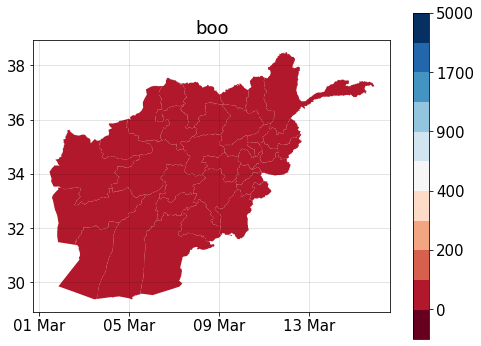

In [148]:
fig,axis=create_new_subplot("boo")
bounds = np.array([-5,0,70,200,300,400,600,900,1200,1700,2400,5000])  #np.array([-0.02, -0.01, 0., 0.01, 0.02, 0.03])
norm2 = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256) 
shapefile.plot(column='cases_per_100k', cmap='RdBu', norm=norm2,ax=axis)
fig.colorbar(axis.collections[0], ax=axis)

In [124]:
shapefile.assign(cl=UserDefined(shapefile["cases_per_100k"].astype(int).dropna(), bins_list))

TypeError: '<' not supported between instances of 'float' and 'str'

In [35]:
shapefile.dtypes

Shape_Leng         float64
Shape_Area         float64
ADM1_EN             object
ADM1_AR             object
ADM1_PCODE          object
ADM1_REF            object
ADM1ALT1EN          object
ADM1ALT2EN          object
ADM1ALT1AR          object
ADM1ALT2AR          object
ADM0_EN             object
ADM0_AR             object
ADM0_PCODE          object
date                object
validOn             object
validTo             object
geometry          geometry
adm1                object
cases_per_100k     float64
dtype: object